# BTC Backtesting with RF signals

## Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load and Merge Data

In [5]:
rf_df = pd.read_csv('Model Output/BTC_RF.csv')
btc_df = pd.read_csv('BTC Raw Data/BTC_FUTURES.csv')

rf_df['Datetime'] = pd.to_datetime(rf_df['Datetime'])
btc_df['Datetime'] = pd.to_datetime(btc_df['date'], format='%m/%d/%Y')

# Merge real close prices into strategy signals
df = pd.merge(rf_df, btc_df[['Datetime', 'close', 'high', 'low']], on='Datetime', how='inner')
df.rename(columns={'close': 'Price'}, inplace=True)
df = df.sort_values('Datetime')

# Convert textual signals to numeric
df['Signal'] = df['Signal'].map({'Buy': 1, 'Sell': -1, 'Hold': 0})

## Compute Indicators

In [7]:
df['MA_9'] = df['Price'].rolling(window=9).mean()
df['Prev_Close'] = df['Price'].shift(1)
df['TR'] = df[['high', 'low', 'Prev_Close']].apply(
    lambda row: max(row['high'] - row['low'],
                    abs(row['high'] - row['Prev_Close']),
                    abs(row['low'] - row['Prev_Close'])), axis=1)
df['ATR_14'] = df['TR'].rolling(window=14).mean()

## Simulate Trading Logic

In [9]:
initial_cash = 100000
cash = initial_cash
position = 0
entry_price = 0
entry_date = None
peak_price = 0
trough_price = float('inf')
atr_mult = 1.5

portfolio_value = []
positions = []
cash_history = []
trades = []
entry_signals = []
exit_signals = []

for i, row in df.iterrows():
    signal = row['Signal']
    price = row['Price']
    ma9 = row['MA_9']
    atr = row['ATR_14']
    date = row['Datetime']

    stop_triggered = False
    if position == 1:
        peak_price = max(peak_price, price)
        if price < peak_price - atr_mult * atr:
            cash *= price / entry_price
            trades.append({'entry_date': entry_date, 'exit_date': date, 'pnl': cash - initial_cash, 'exit_price': price})
            exit_signals.append((date, price))
            position = 0
            stop_triggered = True
    elif position == -1:
        trough_price = min(trough_price, price)
        if price > trough_price + atr_mult * atr:
            cash *= entry_price / price
            trades.append({'entry_date': entry_date, 'exit_date': date, 'pnl': cash - initial_cash, 'exit_price': price})
            exit_signals.append((date, price))
            position = 0
            stop_triggered = True

    if not stop_triggered:
        if signal == 1 and position == 0 and price > ma9:
            position = 1
            entry_price = price
            entry_date = date
            peak_price = price
            entry_signals.append((date, price))
        elif signal == -1 and position == 0 and price < ma9:
            position = -1
            entry_price = price
            entry_date = date
            trough_price = price
            entry_signals.append((date, price))

    if position == 1:
        current_value = cash * price / entry_price
    elif position == -1:
        current_value = cash * entry_price / price
    else:
        current_value = cash

    portfolio_value.append(current_value)
    positions.append(position)
    cash_history.append(cash)

## Results and Stats

In [11]:
df['Position'] = positions
df['Cash'] = cash_history
df['Portfolio_Value'] = portfolio_value
df['Daily_Return'] = df['Portfolio_Value'].pct_change().fillna(0)
df.to_csv("Model Output/BTC_Strategy_Output.csv", index=False)

# Trade stats
btc_trades_df = pd.DataFrame(trades)
total_trades = len(btc_trades_df)
win_rate = (btc_trades_df['pnl'] > 0).mean()
avg_pnl = btc_trades_df['pnl'].mean()
sharpe_ratio = df['Daily_Return'].mean() / df['Daily_Return'].std() * np.sqrt(252) if df['Daily_Return'].std() > 0 else 0

# Max drawdown
rolling_max = df['Portfolio_Value'].cummax()
drawdown = (df['Portfolio_Value'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# 🧾 Print Stats
print("📈 Strategy Performance (Real BTC Prices, MA9 + ATR1.5):")
print(f"Total Trades        : {total_trades}")
print(f"Win Rate (%)        : {win_rate * 100:.2f}")
print(f"Average PnL ($)     : {avg_pnl:.2f}")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Max Drawdown (%)    : {max_drawdown * 100:.2f}")
print(f"Final Portfolio ($) : {df['Portfolio_Value'].iloc[-1]:.2f}")

📈 Strategy Performance (Real BTC Prices, MA9 + ATR1.5):
Total Trades        : 26
Win Rate (%)        : 100.00
Average PnL ($)     : 69292.38
Sharpe Ratio        : 0.94
Max Drawdown (%)    : -34.11
Final Portfolio ($) : 170649.92


C:\Users\Harsh hari\AppData\Local\Temp\ipykernel_39760\358944911.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily_Return'] = df['Portfolio_Value'].pct_change().fillna(0)


## Plot Portfolio + Entry Signals

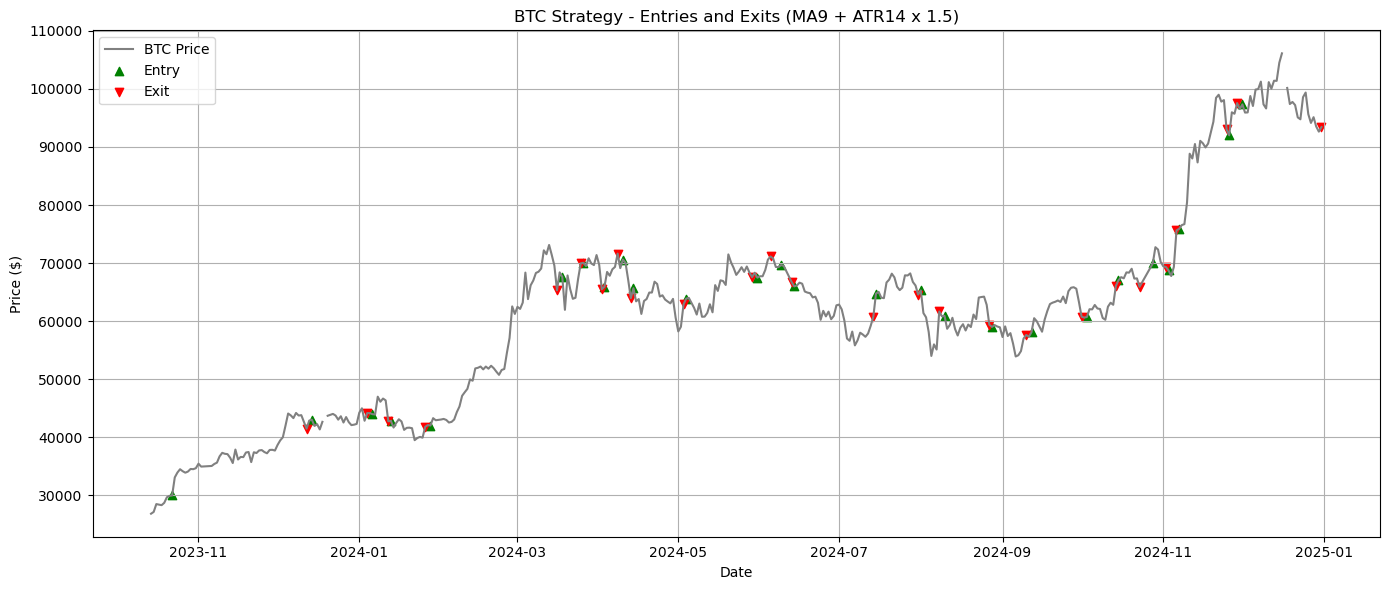

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(df['Datetime'], df['Price'], label='BTC Price', color='gray')
plt.scatter(*zip(*entry_signals), color='green', label='Entry', marker='^')
plt.scatter(*zip(*exit_signals), color='red', label='Exit', marker='v')
plt.title('BTC Strategy - Entries and Exits (MA9 + ATR14 x 1.5)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ETH Backtesting with RF signals

## Load and Merge Data

In [16]:
rf_df = pd.read_csv('Model Output/ETH_RF.csv')
futures_df = pd.read_csv('ETH Raw Data/ETH_FUTURES.csv')

# Parse datetime
rf_df['Datetime'] = pd.to_datetime(rf_df['Datetime'])
futures_df['Datetime'] = pd.to_datetime(futures_df['date'], format='%m/%d/%Y')

# Merge by date and keep relevant prices
df = pd.merge(rf_df, futures_df[['Datetime', 'close', 'high', 'low']], on='Datetime', how='inner')
df.rename(columns={'close': 'Price'}, inplace=True)
df = df.sort_values('Datetime')
df['Signal'] = df['Signal'].map({'Buy': 1, 'Sell': -1, 'Hold': 0})

## Calculate Indicators

In [18]:
# Moving Average (9-day)
df['MA_9'] = df['Price'].rolling(window=9).mean()

# ATR (14-day)
df['Prev_Close'] = df['Price'].shift(1)
df['TR'] = df[['high', 'low', 'Prev_Close']].apply(
    lambda row: max(row['high'] - row['low'],
                    abs(row['high'] - row['Prev_Close']),
                    abs(row['low'] - row['Prev_Close'])), axis=1)
df['ATR_14'] = df['TR'].rolling(window=14).mean()

## Trading Strategy

In [20]:
# Initialize
initial_cash = 100000
cash = initial_cash
position = 0
entry_price = 0
entry_date = None
peak_price = 0
trough_price = float('inf')
atr_mult = 2

portfolio_value = []
positions = []
cash_history = []
trades = []
entry_signals = []
exit_signals = []

# Strategy loop
for _, row in df.iterrows():
    signal = row['Signal']
    price = row['Price']
    ma9 = row['MA_9']
    atr = row['ATR_14']
    date = row['Datetime']

    stop_triggered = False
    if position == 1:
        peak_price = max(peak_price, price)
        if price < peak_price - atr_mult * atr:
            cash *= price / entry_price
            trades.append({'entry_date': entry_date, 'exit_date': date, 'pnl': cash - initial_cash})
            exit_signals.append((date, price))
            position = 0
            stop_triggered = True
    elif position == -1:
        trough_price = min(trough_price, price)
        if price > trough_price + atr_mult * atr:
            cash *= entry_price / price
            trades.append({'entry_date': entry_date, 'exit_date': date, 'pnl': cash - initial_cash})
            exit_signals.append((date, price))
            position = 0
            stop_triggered = True

    if not stop_triggered:
        if signal == 1 and position == 0 and price > ma9:
            position = 1
            entry_price = price
            entry_date = date
            peak_price = price
            entry_signals.append((date, price))
        elif signal == -1 and position == 0 and price < ma9:
            position = -1
            entry_price = price
            entry_date = date
            trough_price = price
            entry_signals.append((date, price))

    if position == 1:
        current_value = cash * price / entry_price
    elif position == -1:
        current_value = cash * entry_price / price
    else:
        current_value = cash

    portfolio_value.append(current_value)
    positions.append(position)
    cash_history.append(cash)

## Performance Metrics

In [22]:
# Add results
df['Position'] = positions
df['Cash'] = cash_history
df['Portfolio_Value'] = portfolio_value
df['Daily_Return'] = df['Portfolio_Value'].pct_change().fillna(0)
df.to_csv("Model Output/ETH_Strategy_Output.csv", index=False)

# Metrics
eth_trades_df = pd.DataFrame(trades)
total_trades = len(eth_trades_df)
win_rate = (eth_trades_df['pnl'] > 0).mean()
avg_pnl = eth_trades_df['pnl'].mean()
sharpe_ratio = df['Daily_Return'].mean() / df['Daily_Return'].std() * np.sqrt(252) if df['Daily_Return'].std() > 0 else 0
rolling_max = df['Portfolio_Value'].cummax()
drawdown = (df['Portfolio_Value'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Print
print("📈 ETH Strategy Performance (MA9 + ATR1.5):")
print(f"Total Trades        : {total_trades}")
print(f"Win Rate (%)        : {win_rate * 100:.2f}")
print(f"Average PnL ($)     : {avg_pnl:.2f}")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Max Drawdown (%)    : {max_drawdown * 100:.2f}")
print(f"Final Portfolio ($) : {df['Portfolio_Value'].iloc[-1]:.2f}")

📈 ETH Strategy Performance (MA9 + ATR1.5):
Total Trades        : 18
Win Rate (%)        : 100.00
Average PnL ($)     : 47722.28
Sharpe Ratio        : 0.68
Max Drawdown (%)    : -45.41
Final Portfolio ($) : 144889.75


## Plot Portfolio + Entry Signals

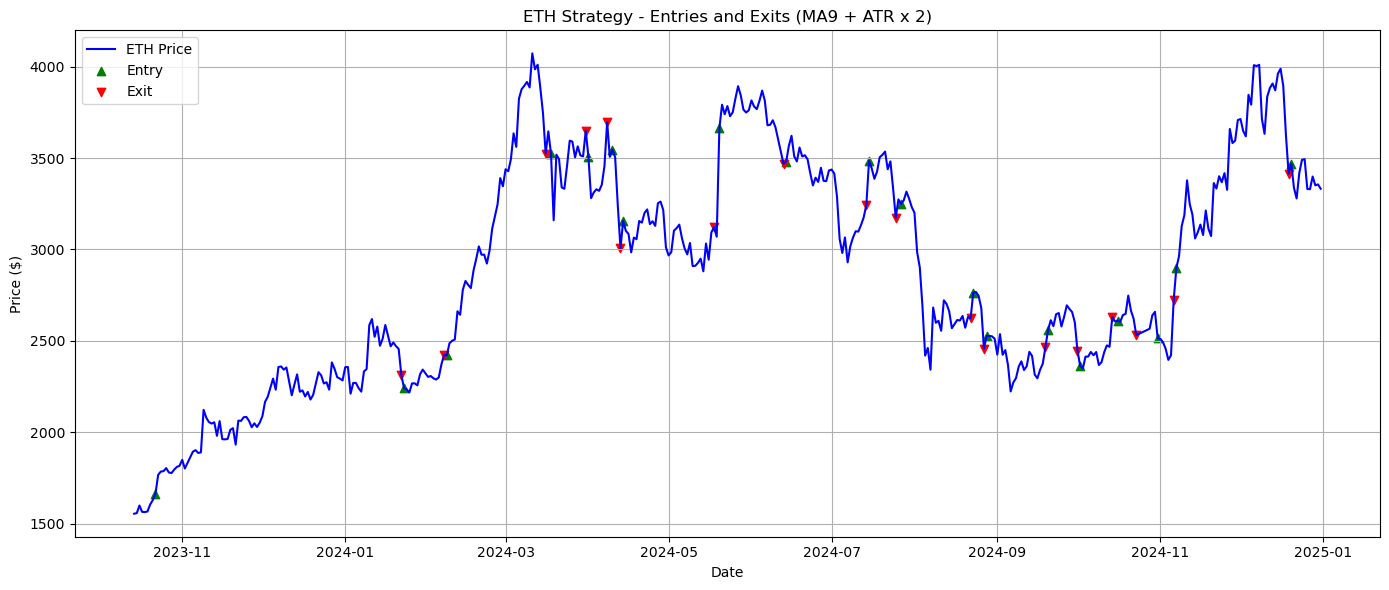

In [24]:
# === Plot Price with Entry and Exit Points ===
plt.figure(figsize=(14, 6))
plt.plot(df['Datetime'], df['Price'], label='ETH Price', color='blue')
if entry_signals:
    plt.scatter(*zip(*entry_signals), color='green', label='Entry', marker='^')
if exit_signals:
    plt.scatter(*zip(*exit_signals), color='red', label='Exit', marker='v')
plt.title('ETH Strategy - Entries and Exits (MA9 + ATR x 2)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Dashboard

In [26]:
pip install streamlit streamlit_jupyter

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install --upgrade streamlit

Note: you may need to restart the kernel to use updated packages.


In [50]:
!streamlit run dashboard.py

^C
